*Note:*

Previously we notice NEMO uses -986.97 i+ 1456.45 in the sinking rate calculation but the notebook has lost. We want to reproduce something similar in this notebook.

In [1]:
import netCDF4 as nc
import numpy as np
import glob
import numpy as np
import pandas as pd
import seaborn as sns;sns.set()
import statsmodels.api as sm
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
sns.set_style('whitegrid')
% matplotlib inline

In [2]:
# data preparation
nc_filename = sorted(glob.glob('/ocean/xiaoxiny/research/data/total/T*.csv'))
nc_filename_= sorted(glob.glob('/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/*.csv'))

filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav_v2/EXH005-btscav_v2_19912016.nc'))
ptrc=nc.Dataset(filename[0])
nav_lon=ptrc.variables['nav_lon'][:]
nav_lat=ptrc.variables['nav_lat'][:]
dep = ptrc.variables['deptht'][:]

bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

Q= 0.0267
k_d_=0.75

In [3]:
# make pretty plots
def refineax(ax,abc='False',ylabkey = 'False'):
    spines_to_remove = ['bottom', 'right']
    for spine in spines_to_remove:
        ax.spines[spine].set_visible(False)
    ax.xaxis.set_ticks_position('top');ax.yaxis.set_ticks_position('left')
    
    ax.spines['top'].set_color('k');ax.spines['left'].set_color('k')
    
    ax.set_ylim(0,4000);ax.set_xlim(0.0,1.5)
    ax.get_yaxis().set_ticks([1000,2000,3000,4000])
    ax.xaxis.set_ticks_position("top")

In [4]:
# color scheme
col=[sns.color_palette("deep")[1],'purple','purple','purple','purple',sns.color_palette("deep")[0],
     sns.color_palette("deep")[0],sns.color_palette("deep")[1],sns.color_palette("deep")[0],'purple','purple',\
     'yellowgreen','yellowgreen','yellowgreen']
mark=['^','s','o','s','^','^','s','>']

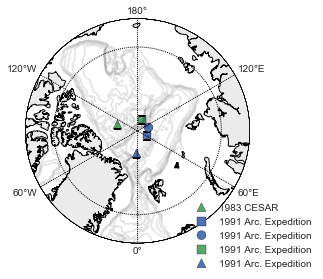

In [5]:
fig = plt.figure(figsize=(15,5));gs = gridspec.GridSpec(1, 7);ax = fig.add_subplot(gs[0,0:2])
m = Basemap(projection='npstere',boundinglat=70,lon_0=0,resolution='l',round='True')

marker_num=0
for station_num in ([0,5,6,7,8]): 
    data=pd.read_csv(nc_filename_[station_num]);lon = data['long.'];lat = data['lat.'];
    y_lon, yy_lat = m(lon[0], lat[0])
    if station_num ==0:
        name= data['name'][0];  
        m.scatter(y_lon,yy_lat,c=col[station_num],marker=mark[marker_num],s=80,label=name[:])
    else:
        name='1991 Arc. Expedition'
        m.scatter(y_lon,yy_lat,c=col[station_num],marker=mark[marker_num],s=80,label=name[:])
    marker_num+=1

# 1st plot: draw basemap
m.drawcoastlines();m.fillcontinents(color = '0.85',alpha=0.5)
m.drawparallels(np.arange(-90.,90.,15.),labels=[0, 0, 0, 0],latmax=90)
m.drawmeridians(np.arange(0.,360.,60.),labels=[1, 1, 1, 1],latmax=90)
x_lon, y_lat = m(nav_lon[:], nav_lat[:])
m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.1)
plt.legend(loc=3,bbox_to_anchor=(0.7, -0.15), fontsize =10)

### Sinking - parameterization

Green (ice =0.97)   s: 616.214459486 205.404819829
Blue (ice =0.62)      s: 948.179956588 316.059985529


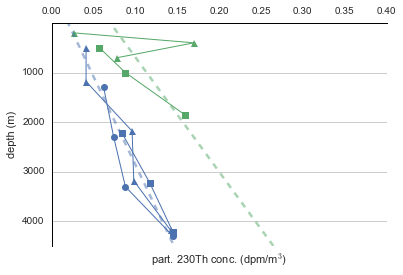

In [6]:
# sinking rate -- on part. Th
# Equation to solve: x = Q/s*z
ax = fig.add_subplot()
marker_num=0

"AR -- > Comnine AR stations; don't read the data above 500m"
err_=[];x_=[];y_=[]

for station_num in ([0,7]):
    # get data
    if station_num ==0:
        data=pd.read_csv(nc_filename_[station_num])
        y= data['depth'].values[2:-2];x=data['230Th part.'][2:-2];err =data['Th_part_err'][2:-2]
        name= data['name'][0] 
    else:
        data=pd.read_csv(nc_filename_[station_num])
        y= data['depth'].values[1:-2];x=data['230Th part.'][1:-2];err =data['Th_part_err'][1:-2]
        name= data['name'][0] 
    # mask bad data
    err=np.ma.masked_where(x<=0,err);x=np.ma.masked_where(y<=0,x);y=np.ma.masked_where(y<=0,y) 
    x=x.compressed();y=y.compressed();err=err.compressed()
    
    # visualiztion 
    plt.plot(x,y,'-o',lw=1,color=col[station_num],marker=mark[marker_num],label=name)
    marker_num+=1
    
    # -- > prepare for linear regression step1: consolidate all mentioned stations in the an array
    for num in range (len(x)):
        err_.append(err[num]);x_.append(x[num]);y_.append(y[num])
        
# -- > prepare for linear regression step2: add constant b (y=ax+b)
y2 = sm.add_constant(y_,prepend=False)
err_=np.array(err_)/np.array(x_);x_=np.array(x_);y_=np.array(y_)

# -- > fit & plot
LinearReg = sm.WLS(x_, y2,weights=1./err_).fit()
plt.plot([0, 1.6],[0, 1.6]/LinearReg.params[0]-LinearReg.params[1]/LinearReg.params[0], \
         '--.',c=col[station_num],linewidth=2.5,alpha=0.5)

s=0.0267/LinearReg.params[0];print ('Green (ice =0.97)   s:',s,s/3)

#============================
"NB -- > Comnine NB stations"
err_=[];x_=[];y_=[]

for station_num in ([5,6,8]):
    # get data
    data=pd.read_csv(nc_filename_[station_num])
    y= data['depth'].values[1:];x=data['230Th part.'][1:];err =data['Th_part_err'][1:]
    
    # mask bad data
    err=np.ma.masked_where(x<=0,err);x=np.ma.masked_where(y<=0,x);y=np.ma.masked_where(y<=0,y) 
    x=x.compressed();y=y.compressed();err=err.compressed()
    # visualization - label names: cut it short
    name= data['name'][0][:-4];    
    plt.plot(x,y,'-o',lw=1,color=col[station_num],marker=mark[marker_num],label=name)
    marker_num+=1
    
    # -- > prepare for linear regression step1: 
    for num in range (len(x)):
        err_.append(err[num]);x_.append(x[num]);y_.append(y[num])
        
# -- > prepare for linear regression step2: 
y2 = sm.add_constant(y_,prepend=False)
err_=np.array(err_)/np.array(x_);x_=np.array(x_);y_=np.array(y_)

# -- > fit & plot
LinearReg = sm.WLS(x_, y2,weights=1./err_).fit()
plt.plot([0, 1.6],[0, 1.6]/LinearReg.params[0]-LinearReg.params[1]/LinearReg.params[0], \
         '--.',c=col[station_num],linewidth=2.5,alpha=0.5)

s_=0.0267/LinearReg.params[0];print ('Blue (ice =0.62)      s:',s_,s_/3)
     
# make pretty plot    
refineax(plt.gca())
plt.xlim(0,0.4);plt.ylim(0,4500);plt.gca().invert_yaxis();
plt.gca().xaxis.grid(False)
plt.xlabel('part. 230Th conc. (dpm/m$^3$)');plt.ylabel('depth (m)')

In [7]:
s_slope=(s_-s)/(0.62-0.97)
s_cons = s_ - s_slope*0.62
print ("Sinking: %s*i + %s"%(s_slope,s_cons))

Sinking: -948.472848863*i + 1536.23312288


### k - parameterization

Green (ice =0.97):      k 0.0921536675818 k_1 0.75 Q/k 0.289733449581
Blue (ice =0.62):     k 0.230693933354 k_1 0.75 Q/k 0.115737763936


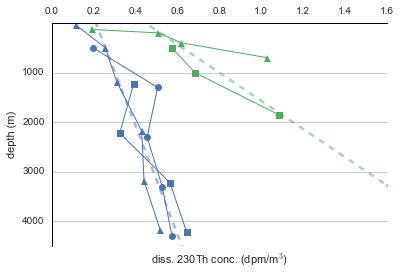

In [8]:
# k -- on diss Th
# Equation to solve: x = Q/k + (k_d/k_a)(Q/s*z+c)
ax = fig.add_subplot()
marker_num=0

"AR -- > Comnine AR stations"
err_=[];x_=[];y_=[]

for station_num in ([0,7]):
    # get data
    data=pd.read_csv(nc_filename_[station_num])
    y= data['depth'].values[1:-2];x=data['230Th diss.'][1:-2];err =data['Th_diss_err'][1:-2];name= data['name'][0]
    
    # mask bad data
    err=np.ma.masked_where(x<=0,err);x=np.ma.masked_where(y<=0,x);y=np.ma.masked_where(y<=0,y) 
    x=x.compressed();y=y.compressed();err=err.compressed()
    # visualization     
    plt.plot(x,y,'-o',lw=1,color=col[station_num],marker=mark[marker_num],label=name)
    marker_num+=1
    
    # -- > prepare for linear regression step1: 
    for num in range (len(x)):
        err_.append(err[num]);x_.append(x[num]);y_.append(y[num])
        
# -- > prepare for linear regression step2:         
y2 = sm.add_constant(y_,prepend=False)
err_=np.array(err_)/np.array(x_);x_=np.array(x_);y_=np.array(y_)

# -- > fit & plot
LinearReg = sm.WLS(x_, y2,weights=1./err_).fit()
plt.plot([0, 1.6],[0, 1.6]/LinearReg.params[0]-LinearReg.params[1]/LinearReg.params[0], \
         '--.',c=col[station_num],linewidth=2.5,alpha=0.5)
# note: slope = params[0]; constant = params [1]
A21=LinearReg.params[0]; B21=LinearReg.params[1] 
a=LinearReg.params[0];   b=LinearReg.params[1] #cons.  

Kvalue=Q/s*k_d_/a
print ('Green (ice =0.97):      k',Kvalue,'k_1',k_d_,'Q/k',Q/Kvalue)
    
#====================================
"NB -- > Comnine NB stations"

err_=[];x_=[];y_=[]

for station_num in ([5,6,8]):
    # get data
    data=pd.read_csv(nc_filename_[station_num])
    y= data['depth'].values[:];x=data['230Th diss.'][:];err =data['Th_diss_err'][:];name= data['name'][0];
    
    # mask bad data
    err=np.ma.masked_where(x<=0,err);x=np.ma.masked_where(y<=0,x);y=np.ma.masked_where(y<=0,y) 
    x=x.compressed();y=y.compressed();err=err.compressed()
    
    # visualization     
    plt.plot(x,y,'-o',lw=1,color=col[station_num],marker=mark[marker_num],label=name)
    marker_num+=1
    
    # -- > prepare for linear regression step1: 
    for num in range (len(x)):
        err_.append(err[num]);x_.append(x[num]);y_.append(y[num])
        
# -- > prepare for linear regression step2:             
y2 = sm.add_constant(y_,prepend=False)
err_=np.array(err_)/np.array(x_);x_=np.array(x_);y_=np.array(y_)

# -- > fit & plot
LinearReg = sm.OLS(x_, y2,weights=1/err_).fit()
plt.plot([0, 1.6],[0, 1.6]/LinearReg.params[0]-LinearReg.params[1]/LinearReg.params[0], \
         '--.',c=col[station_num],linewidth=2.5,alpha=0.5)
# note: slope = params[0]; constant = params [1]
A22=LinearReg.params[0];B22=LinearReg.params[1]
a=LinearReg.params[0];  b=LinearReg.params[1]    

Kvalue_=Q/s_*k_d_/a
print ('Blue (ice =0.62):     k',Kvalue_,'k_1',k_d_,'Q/k',Q/Kvalue_)

# make pretty plot    
refineax(plt.gca())
plt.ylim(0,4500);plt.gca().invert_yaxis();plt.xlim(0,1.6);
plt.gca().xaxis.grid(False)
plt.xlabel('diss. 230Th conc. (dpm/m$^3$)');plt.ylabel('depth (m)')

In [9]:
# k - parameterization
k_slope=(Kvalue_-Kvalue)/(0.62-0.97)
k_cons = Kvalue_ - k_slope*0.62
print ("k: %s*i + %s"%(k_slope,k_cons))

k: -0.395829330779*i + 0.476108118437


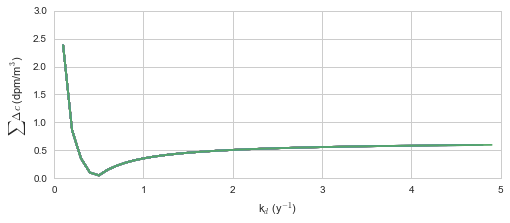

In [10]:
# quick plot for j agaist dis - (distance between intercepts)
k=[];dis=[] 
fig, ax = plt.subplots(figsize = (8,3))
    
for k_d in range(0,50):
    #for k_d: loop over 0 ~ 5; normally k ~ 2
    k_d = k_d/10. 
    Kvalue1=Q/s*k_d/A21;  Kvalue2=Q/s_*k_d/A22
    d = abs(Q/Kvalue1 - B21);d+= abs(Q/Kvalue2 - B22)
    k.append(k_d);dis.append(d);plt.plot(k,dis)
       
# labels
plt.xlabel('k$_d$ (y$^{-1}$)');plt.ylabel('$ \sum \Delta c$ (dpm/m$^3$)')
ax.set_ylim(-0.,3); plt.show()